In [2]:
import torch
from simple_fem import FEM, Quad, import_mesh
import matplotlib.pyplot as plt
from math import sqrt
import meshio as meshio
import numpy as np

torch.set_default_dtype(torch.double)


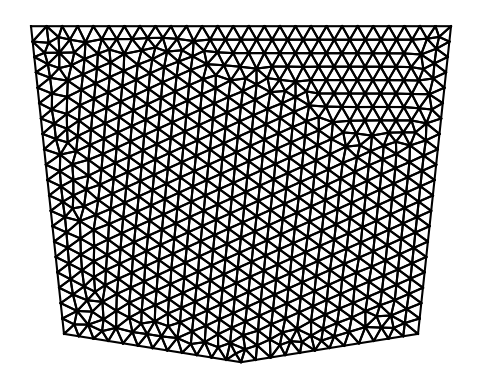

In [55]:
# Import mesh
fillet = import_mesh("golfy.vtu", 1000.0, 0.33)

# Constrain hinges on top
top = fillet.nodes[0, 0] == 0
fillet.constraints[top, :] = True

# # Constrain bottom boundary
# bottom = fillet.nodes[:, 1] == 0.0
# fillet.constraints[bottom, 1] = True

# # Force at right boundary
# right = fillet.nodes[:, 0] == 60.0
# fillet.forces[right, 0] = 1.0
# fillet.forces[1, 0] = 0.5
# fillet.forces[2, 0] = 0.5

# Plot the fillet
fillet.plot()

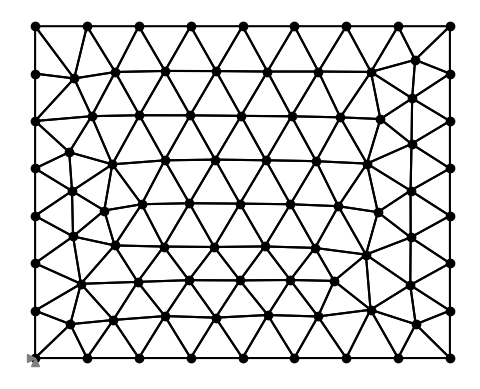

In [5]:
# Import mesh
fillet = import_mesh("blank.vtu", 1000.0, 0.33)

# Constrain hinges on top
top = fillet.nodes[0, 0] == 0
fillet.constraints[top, 1] = True

# # Constrain bottom boundary
# bottom = fillet.nodes[:, 1] == 0.0
# fillet.constraints[bottom, 1] = True

# # Force at right boundary
# right = fillet.nodes[:, 0] == 60.0
# fillet.forces[right, 0] = 1.0
# fillet.forces[1, 0] = 0.5
# fillet.forces[2, 0] = 0.5

# Plot the fillet
fillet.plot()

In [3]:
mesh = meshio.read("golfy.vtu")
print(torch.from_numpy(mesh.points[:, 0].astype(np.float64)))

tensor([230.3535, 250.0000,   0.0000,  19.6465, 125.0000, 231.3358, 232.3181,
        233.3004, 234.2828, 235.2651, 236.2474, 237.2298, 238.2121, 239.1944,
        240.1767, 241.1591, 242.1414, 243.1237, 244.1060, 245.0884, 246.0707,
        247.0530, 248.0353, 249.0177, 240.7407, 231.4815, 222.2222, 212.9630,
        203.7037, 194.4444, 185.1852, 175.9259, 166.6667, 157.4074, 148.1481,
        138.8889, 129.6296, 120.3704, 111.1111, 101.8519,  92.5926,  83.3333,
         74.0741,  64.8148,  55.5556,  46.2963,  37.0370,  27.7778,  18.5185,
          9.2593,   0.9823,   1.9647,   2.9470,   3.9293,   4.9116,   5.8940,
          6.8763,   7.8586,   8.8409,   9.8233,  10.8056,  11.7879,  12.7702,
         13.7526,  14.7349,  15.7172,  16.6996,  17.6819,  18.6642,  28.4260,
         37.2054,  45.9849,  54.7644,  63.5438,  72.3233,  81.1027,  89.8822,
         98.6616, 107.4411, 116.2205, 221.5740, 212.7946, 204.0151, 195.2356,
        186.4562, 177.6767, 168.8973, 160.1178, 151.3384, 142.55

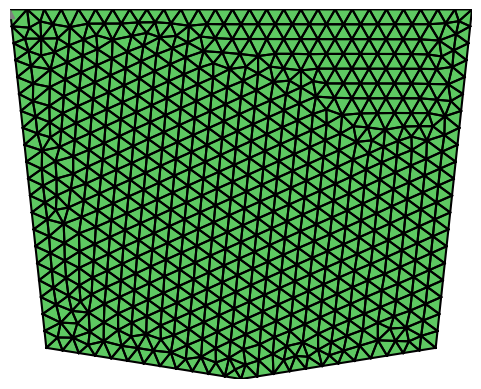

In [61]:
# Solve
u, f = fillet.solve()

# Plot
fillet.plot(u, node_property=torch.norm(u, dim=1))

In [29]:
# Distances between all nodes - use torch.cdist()
r = torch.cdist(fillet.nodes, fillet.nodes)

# Set epsilon
epsilon = 0.2

# Compute phi
phi = torch.exp(-((epsilon * r) ** 2))


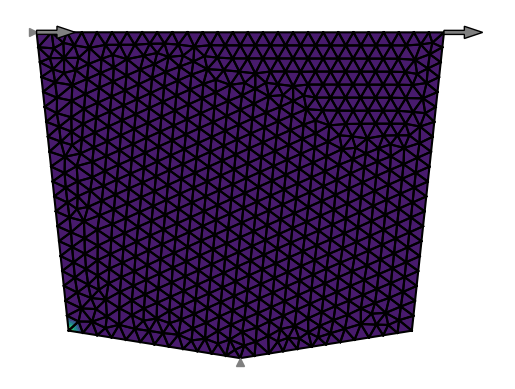

In [30]:
# Extract function values for RBF associated with Node 3
rbf_3 = phi[3, :]
fillet.plot(u, node_property=rbf_3)

In [14]:
def bisection(f, a, b, max_iter=50, tol=1e-12):
    # Bisection method always finds a root, even with highly non-linear grad
    i = 0
    while (b - a) > tol:
        c = (a + b) / 2.0
        if i > max_iter:
            raise Exception(f"Bisection did not converge in {max_iter} iterations.")
        if f(a) * f(c) > 0:
            a = c
        else:
            b = c
        i += 1
    return c

In [15]:
def optimize(fem, rho_0, rho_min, rho_max, V_0, iter=100, xi=0.5, m=0.2, p=1.0, r=0.0):
    rho = [rho_0]
    vols = d * fem.areas()

    # Check if there is a feasible solution before starting iteration
    if torch.inner(rho_min, vols) > V_0:
        raise Exception("rho_min is not compatible with V_0.")

    # Precompute filter weights
    if r > 0.0:
        H = r - fem.dist
        H[fem.dist > r] = 0.0

    # Iterate solutions
    for k in range(iter):
        # Adjust thickness variables
        fem.thickness = d * rho[k] ** p

        # Compute solution
        u_k, f_k = fem.solve()

        # Compute sensitivities
        w_k = fem.element_strain_energies(u_k)
        sensitivity = -p * d * rho[k] ** (p - 1) * 2.0 * w_k

        # Filter sensitivities (if r provided)
        if r > 0.0:
            sensitivity = H @ (rho[k] * sensitivity) / H.sum(dim=0) / rho[k]

        # For a certain value of mu, apply the iteration scheme
        def make_step(mu):
            G_k = -sensitivity / (mu * vols)
            upper = torch.min(rho_max, (1 + m) * rho[k])
            lower = torch.max(rho_min, (1 - m) * rho[k])
            rho_trial = G_k**xi * rho[k]
            return torch.maximum(torch.minimum(rho_trial, upper), lower)

        # Constraint function
        def g(mu):
            rho_k = make_step(mu)
            return torch.dot(rho_k, vols) - V_0

        # Find the root of g(mu)
        mu = bisection(g, 1e-10, 100.0)

        # Evaluation
        compliance = torch.inner(f_k.ravel(), u_k.ravel())
        print(f"Iteration k={k} - Compliance: {compliance:.5f}")

        rho.append(make_step(mu))

    return rho

In [16]:
# Initial thickness, minimum thickness, maximum thickness
rho_0 = 0.5 * torch.ones(len(square.elements))
rho_min = 0.01 * torch.ones_like(rho_0)
rho_max = 1.0 * torch.ones_like(rho_0)

# Initial volume (40% of maximum design volume)
vols = d * square.areas()
V0 = 0.4 * vols.sum()

In [20]:
# Initial thickness, minimum thickness, maximum thickness
rho_0 = 0.5
rho_min = 0.01
rho_max = 1.0

# Initial volume (40% of maximum design volume)
vols = d
V0 = 0.4

Iteration k=0 - Compliance: 0.16330
Iteration k=1 - Compliance: 0.30641
Iteration k=2 - Compliance: 0.51798
Iteration k=3 - Compliance: 0.71641
Iteration k=4 - Compliance: 0.76867
Iteration k=5 - Compliance: 0.74889
Iteration k=6 - Compliance: 0.72383
Iteration k=7 - Compliance: 0.66220
Iteration k=8 - Compliance: 0.62117
Iteration k=9 - Compliance: 0.57177
Iteration k=10 - Compliance: 0.54382
Iteration k=11 - Compliance: 0.49942
Iteration k=12 - Compliance: 0.46861
Iteration k=13 - Compliance: 0.43240
Iteration k=14 - Compliance: 0.42656
Iteration k=15 - Compliance: 0.40687
Iteration k=16 - Compliance: 0.39867
Iteration k=17 - Compliance: 0.38936
Iteration k=18 - Compliance: 0.38642
Iteration k=19 - Compliance: 0.38118
Iteration k=20 - Compliance: 0.37900
Iteration k=21 - Compliance: 0.37527
Iteration k=22 - Compliance: 0.37438
Iteration k=23 - Compliance: 0.37213
Iteration k=24 - Compliance: 0.37275
Iteration k=25 - Compliance: 0.37180
Iteration k=26 - Compliance: 0.37333
Iteration k

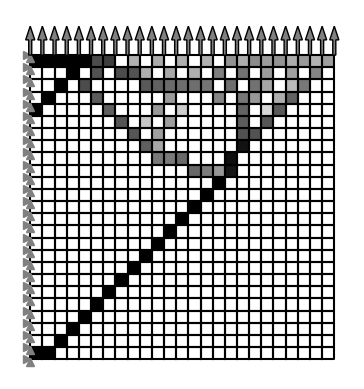

In [17]:
# Optimize and visualize results
d_opt = optimize(square, rho_0, rho_min, rho_max, V0, iter=50, p=3.0, r=0.0)
square.plot(element_property=d_opt[-1])

Iteration k=0 - Compliance: 0.16330
Iteration k=1 - Compliance: 0.30901
Iteration k=2 - Compliance: 0.52065
Iteration k=3 - Compliance: 0.71461
Iteration k=4 - Compliance: 0.76669
Iteration k=5 - Compliance: 0.75358
Iteration k=6 - Compliance: 0.73317
Iteration k=7 - Compliance: 0.68036
Iteration k=8 - Compliance: 0.64661
Iteration k=9 - Compliance: 0.60868
Iteration k=10 - Compliance: 0.59282
Iteration k=11 - Compliance: 0.56617
Iteration k=12 - Compliance: 0.55547
Iteration k=13 - Compliance: 0.54053
Iteration k=14 - Compliance: 0.53521
Iteration k=15 - Compliance: 0.52614
Iteration k=16 - Compliance: 0.52163
Iteration k=17 - Compliance: 0.51252
Iteration k=18 - Compliance: 0.51046
Iteration k=19 - Compliance: 0.50503
Iteration k=20 - Compliance: 0.50531
Iteration k=21 - Compliance: 0.50154
Iteration k=22 - Compliance: 0.50267
Iteration k=23 - Compliance: 0.49944
Iteration k=24 - Compliance: 0.50086
Iteration k=25 - Compliance: 0.49784
Iteration k=26 - Compliance: 0.49939
Iteration k

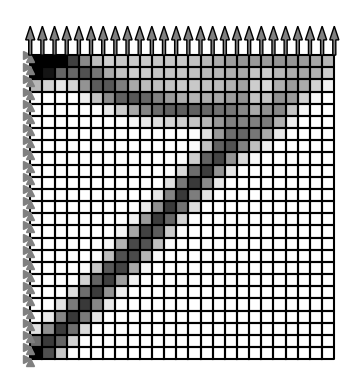

In [19]:
# Optimize and visualize results
d_opt = optimize(square, rho_0, rho_min, rho_max, V0, iter=250, p=3.0, r=0.06)
square.plot(element_property=d_opt[-1])